In [ ]:
!pip install pyspark
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving bank-full.csv to bank-full (3).csv


In [ ]:
#PRETTY PRINTING TABLES SPARK DATAFRAMES
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [ ]:
sandbox = ''
PATH_DATA = '/data/sandboxes/'+sandbox+'/data/all_data/'



# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es predecir si un cliente en cuestión comprará el producto o no.



## Información sobre las variables del dataset

### Datos del cliente bancario
1. age: edad
2. job: tipo de trabajo
3. marital: estado civil (nota: "divorced" implica tanto divorciado como viudo)
4. education: nivel de estudios.
5. default: ¿no ha pagado alguna cuota de un crédito?
6. balance: saldo medio anual, en euros
7. housing: ¿tiene una hipoteca?
8. loan: ¿tiene un crédito?

### Relacionado con el último contacto con el cliente en la campaña actual
9. contact: tipo de comunicación del último contacto
10. day: día de la fecha de último contacto
11. month: mes de la fecha de último contacto
12. duration: duración del último contacto, en segundos

### Otros atributos:
13. campaign: número de contactos llevados a cabo durante esta campaña y para este cliente (incluye el último contacto)
14. pdays: número de días que han pasado desde que el cliente fue contactado por última vez durante la pasada campaña (-1 significa que el cliente no fue contactado)
15. previous: número de contactos que se han llevado a cabo antes de esta campaña y para este cliente
16. poutcome: resultado de la última campaña de marketing

### Variable de salida (target):
17. y: ¿tiene el cliente contratado un depósito a plazo fijo?

## Carga de librerías

In [ ]:
###En esta sección lo que hacemos es cargar las librerias que vamos a utilizar para resolver el ejercicio
import random
import re

import numpy as np
import pandas as pd
from datetime import date, datetime
from collections import Counter
import numpy as np

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
sns.set(color_codes=True)

from scipy.stats import kstest
from scipy import stats

from pyspark.sql.functions import min, max, mean
from pyspark.sql.functions import stddev_samp
from pyspark.ml.stat import KolmogorovSmirnovTest
from pyspark.ml.stat import Correlation

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



## Lectura de datos

In [ ]:
df = spark.read.csv('bank-full.csv',sep=';',inferSchema=True,header=True)

In [ ]:
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

# Data Wrangling

## Formateo de variables

Validar hay necesidad de modificar el tipo de variable int, str, bool

In [ ]:
#from pyspark.sql.types import StringType, DoubleType,
#IntegerType, StructType, StructField, FloatType

##1)Observamos que los datos contienen un formato uniforme, es decir: están todos en minúsculas y no tienen espacios que sean
##necesarios para cambiar a guión bajo
##2) También observamos con el tipo de variables que vamos a estar manipulando durante el ejercicio y podemos observar que todas las variables f
##fueron correctamente inferidas y etiquetadas

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



## Duplicados

Estudio de registros duplicados

In [ ]:
###observamos cuantas observaciones tenemos para antes de aplicar la función de eliminar duplicados nos indique cuantas
##observaciones eliminamos
df.count()

45211

In [ ]:
###Nos damos cuenta que no hay duplicados tomando en cuenta todas las columnas
df_duplicados = df.dropDuplicates()
df_duplicados.count()

45211

## Variabilidad entre columnas

Ver si es posible descartar algunas columnas que no tienen variabilidad

In [ ]:
####para las variables númericas sacamos el promedio, mínimo , desviación estandar y máximo con sus debidas graficas
numeric_columns = [col_name for col_name, col_type in df.dtypes if col_type in ["int", "double"]]

for col_name in numeric_columns:
    desc_stats = df.select(col_name).describe().toPandas()


    # Mostrar estadísticas descriptivas en forma tabular
    print(desc_stats)

    # Mostrar salto entre gráficos
    print('\n' + '='*80 + '\n')

  summary                 age
0   count               45211
1    mean   40.93621021432837
2  stddev  10.618762040975408
3     min                  18
4     max                  95


  summary             balance
0   count               45211
1    mean  1362.2720576850766
2  stddev  3044.7658291685243
3     min               -8019
4     max              102127


  summary                day
0   count              45211
1    mean  15.80641879188693
2  stddev  8.322476153044596
3     min                  1
4     max                 31


  summary            duration
0   count               45211
1    mean   258.1630797814691
2  stddev  257.52781226517095
3     min                   0
4     max                4918


  summary           campaign
0   count              45211
1    mean  2.763840658246887
2  stddev  3.098020883279184
3     min                  1
4     max                 63


  summary               pdays
0   count               45211
1    mean   40.19782796222158
2  stddev  1

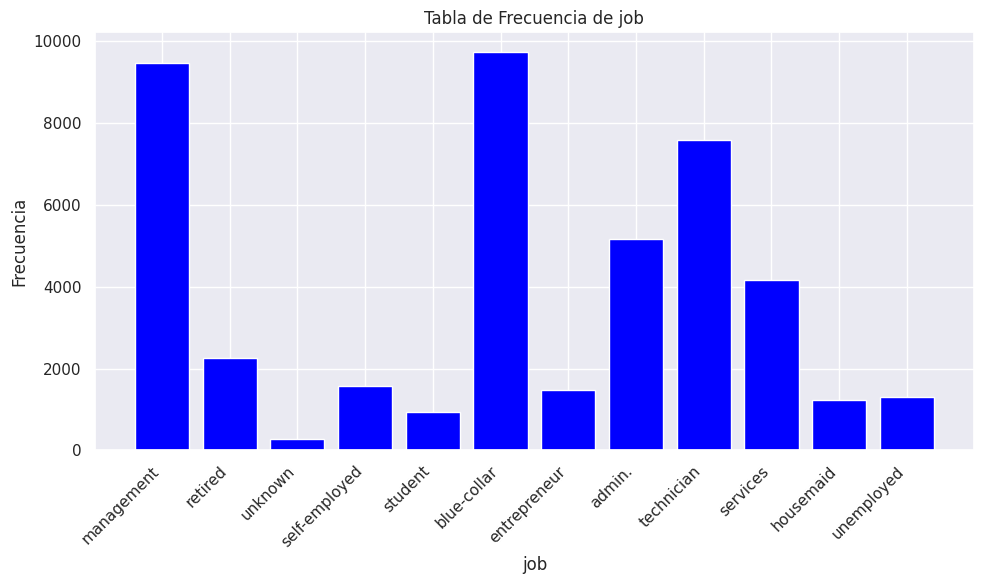

              job  count
0      management   9458
1         retired   2264
2         unknown    288
3   self-employed   1579
4         student    938
5     blue-collar   9732
6    entrepreneur   1487
7          admin.   5171
8      technician   7597
9        services   4154
10      housemaid   1240
11     unemployed   1303




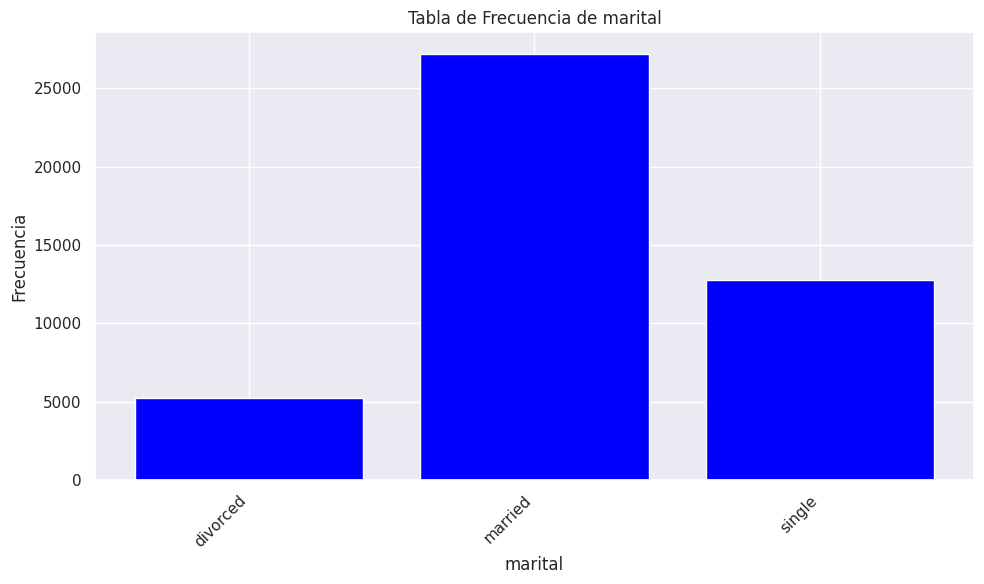

    marital  count
0  divorced   5207
1   married  27214
2    single  12790




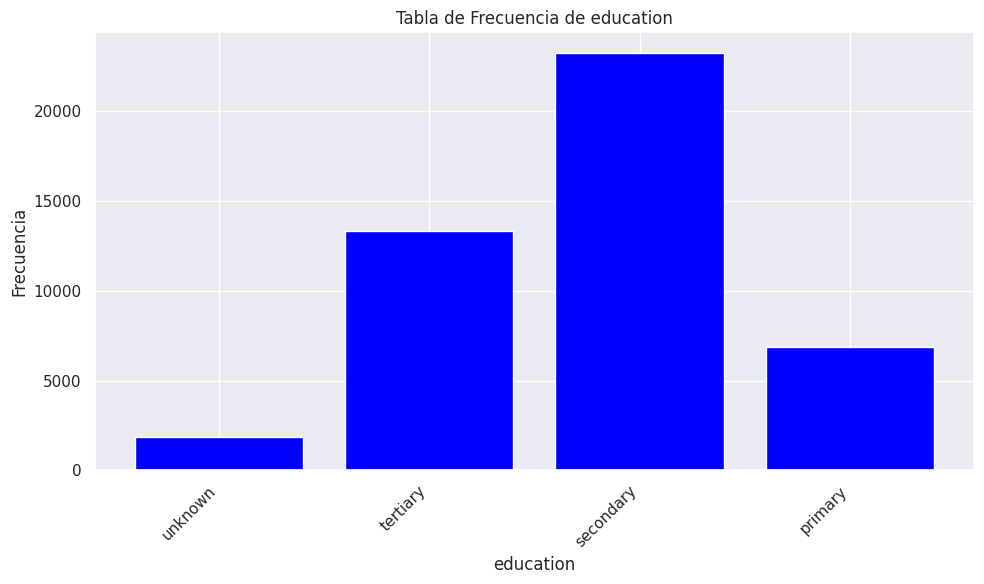

   education  count
0    unknown   1857
1   tertiary  13301
2  secondary  23202
3    primary   6851




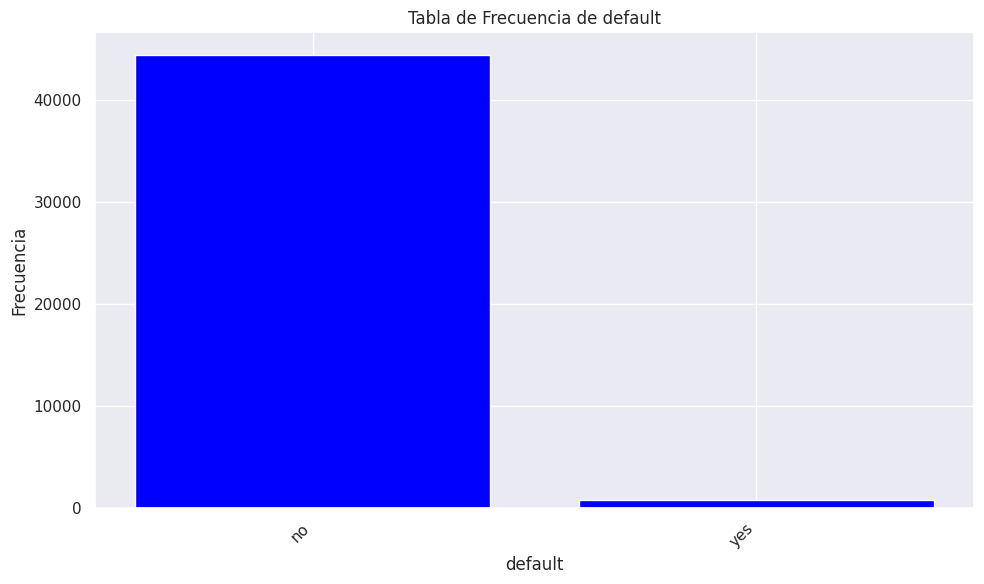

  default  count
0      no  44396
1     yes    815




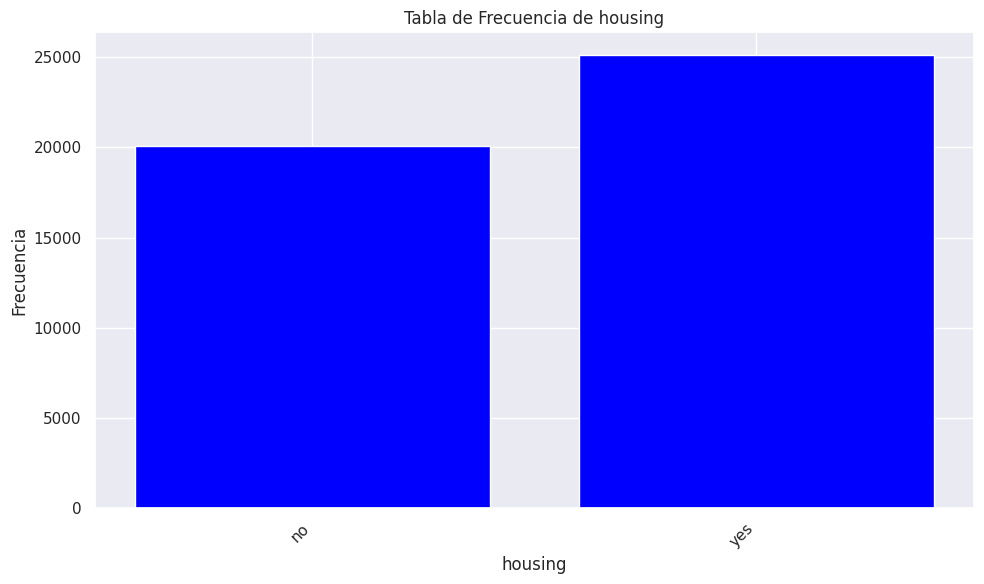

  housing  count
0      no  20081
1     yes  25130




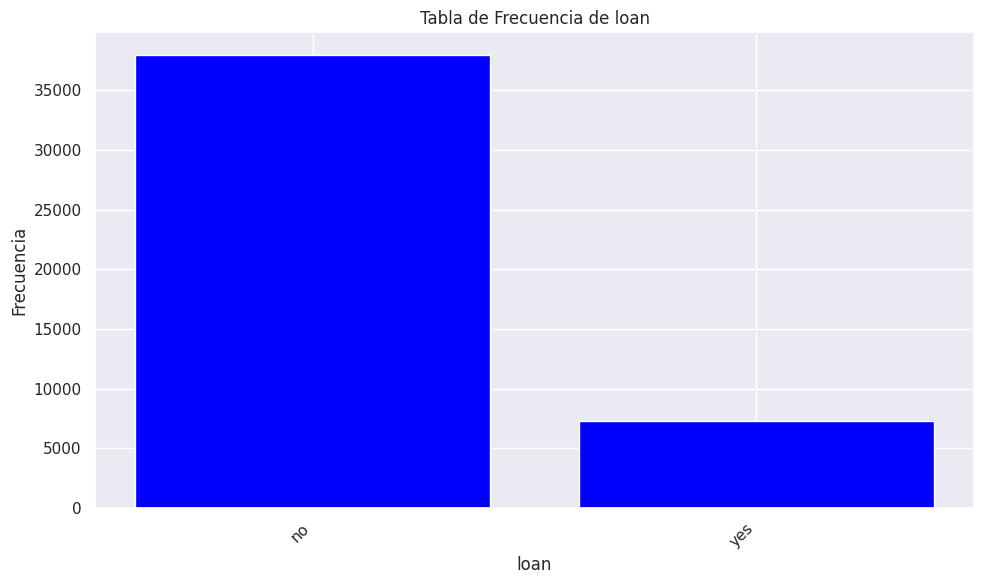

  loan  count
0   no  37967
1  yes   7244




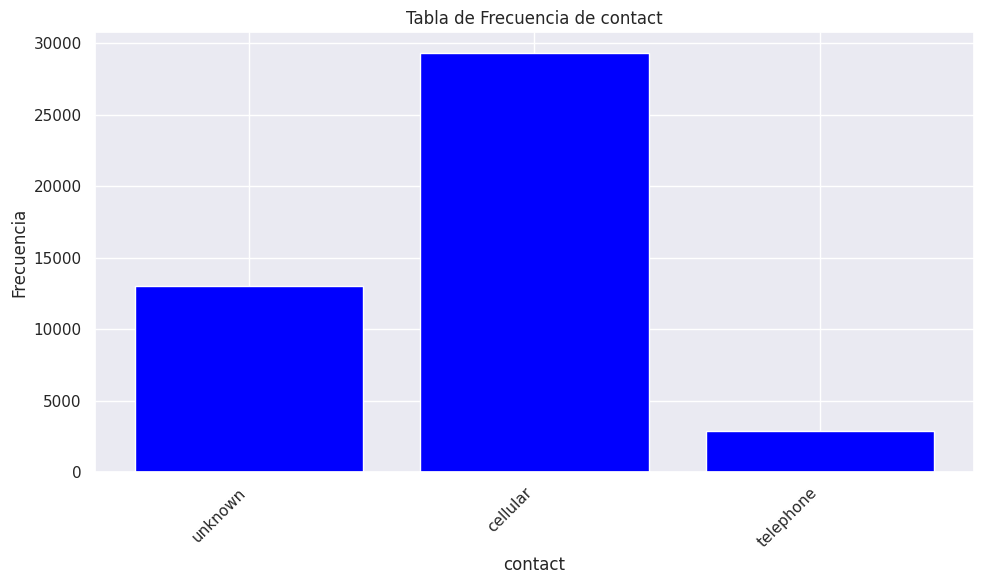

     contact  count
0    unknown  13020
1   cellular  29285
2  telephone   2906




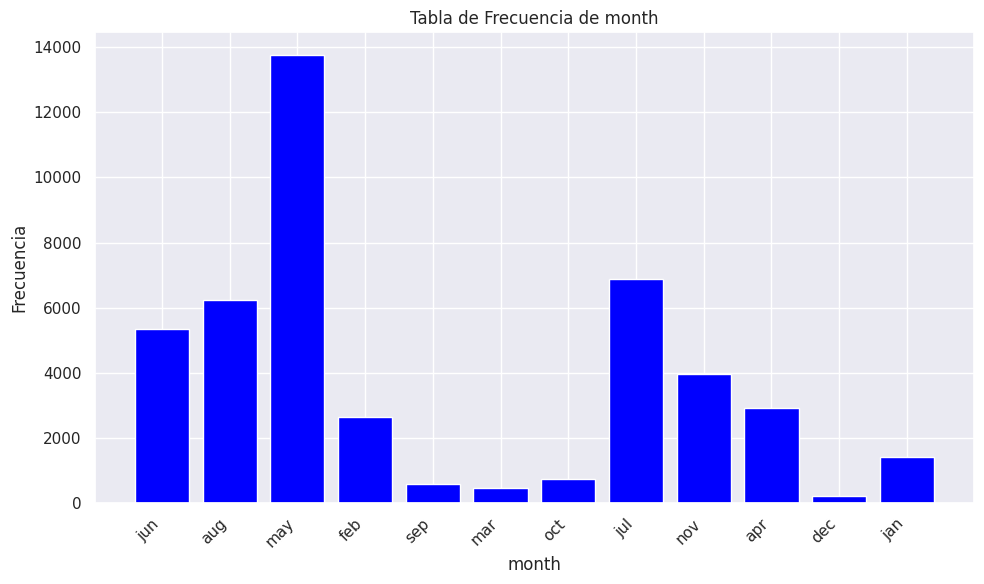

   month  count
0    jun   5341
1    aug   6247
2    may  13766
3    feb   2649
4    sep    579
5    mar    477
6    oct    738
7    jul   6895
8    nov   3970
9    apr   2932
10   dec    214
11   jan   1403




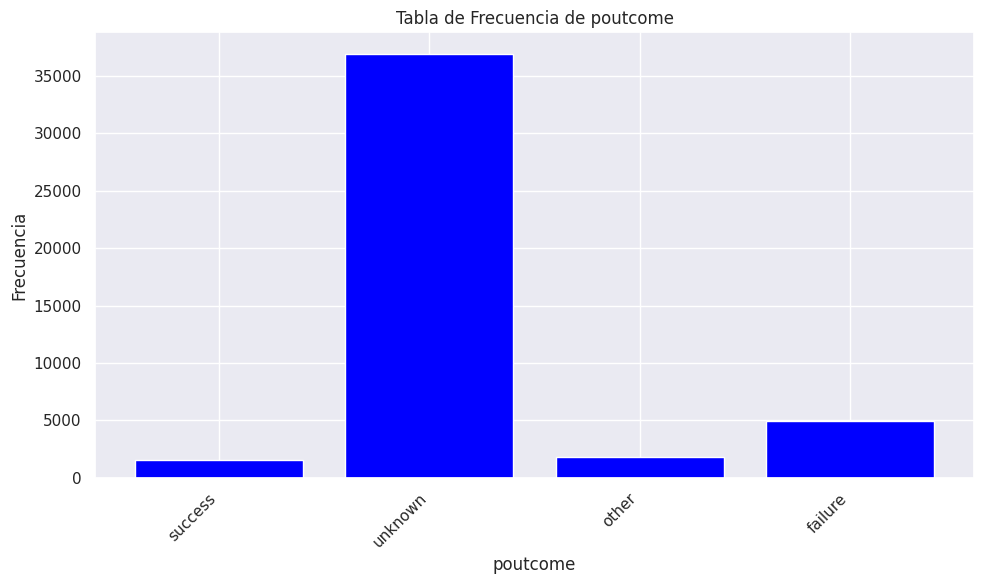

  poutcome  count
0  success   1511
1  unknown  36959
2    other   1840
3  failure   4901




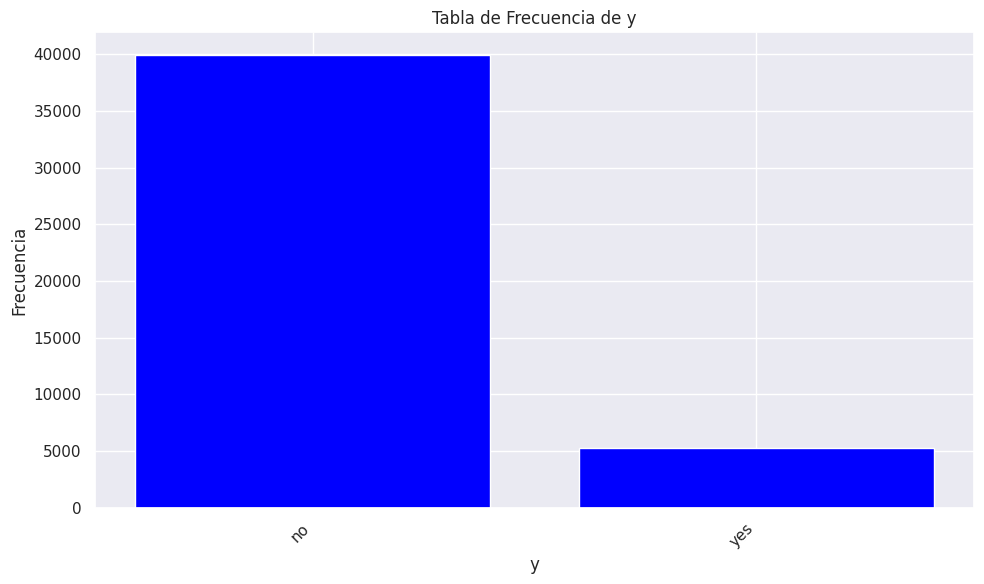

     y  count
0   no  39922
1  yes   5289




In [ ]:
##En la siguiente sección sacamos una estadistica general de nuestras variables string, con su debida tabla de frecuencias y su gráfica
string_columns = [col_name for col_name, col_type in df.dtypes if col_type == "string"]

for col_name in string_columns:
    freq_table = df.groupBy(col_name).count().toPandas()

    plt.figure(figsize=(10, 6))
    plt.bar(freq_table[col_name], freq_table['count'], color='blue')
    plt.title(f'Tabla de Frecuencia de {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print(freq_table)

    # Mostrar salto entre gráficos
    print('\n' + '='*80 + '\n')

## Nulos

Tratamiento de valores ausentes

In [ ]:
#Se obtienen los porcentajes de valores nulos en cada columna a través de un ciclo for
n_rows = df.count()

for column in df.columns:
  n_missing = df.filter(F.col(column).isNull()).count()
  perc_missing = 100 * n_missing / n_rows
  print(column, round(perc_missing, 2))

age 0.0
job 0.0
marital 0.0
education 0.0
default 0.0
balance 0.0
housing 0.0
loan 0.0
contact 0.0
day 0.0
month 0.0
duration 0.0
campaign 0.0
pdays 0.0
previous 0.0
poutcome 0.0
y 0.0


## Frecuencia de valores

Análisis de variables categóricas para ver la ocurrencia de sus valores únicos

In [ ]:
#Se ve quiénes son los valores distintos a través de un distinct
for col in df.columns:
  value = df.select(col).distinct().count()
  print("En la columna: ", col," Hay", value, " valores únicos")


En la columna:  age  Hay 77  valores únicos
En la columna:  job  Hay 12  valores únicos
En la columna:  marital  Hay 3  valores únicos
En la columna:  education  Hay 4  valores únicos
En la columna:  default  Hay 2  valores únicos
En la columna:  balance  Hay 7168  valores únicos
En la columna:  housing  Hay 2  valores únicos
En la columna:  loan  Hay 2  valores únicos
En la columna:  contact  Hay 3  valores únicos
En la columna:  day  Hay 31  valores únicos
En la columna:  month  Hay 12  valores únicos
En la columna:  duration  Hay 1573  valores únicos
En la columna:  campaign  Hay 48  valores únicos
En la columna:  pdays  Hay 559  valores únicos
En la columna:  previous  Hay 41  valores únicos
En la columna:  poutcome  Hay 4  valores únicos
En la columna:  y  Hay 2  valores únicos


## Distribución normal

In [26]:
vars_numeric = ['age','balance','duration','campaign','pdays','previous']
def is_normal(df,columna, alpha=0.05):
  media=df.select(F.avg(F.col(columna))).take(1)[0][0]
  std_dev=df.select(F.stddev(F.col(columna))).take(1)[0][0]
  ksResult = KolmogorovSmirnovTest.test(df, columna , 'norm', media, std_dev).first()
  p_value= ksResult.pValue
  es_normal = p_value>=alpha
  return p_value,es_normal

for col in vars_numeric:
  print('La columna {} tuvo un p-value de {} por lo que consideramos la variable como {} normal.'.format(col,is_normal(df,col)[0],
                                                                                           '' if is_normal(df,col)[1] else 'no'))

La columna age tuvo un p-value de 3.4533487180965494e-11 por lo que consideramos la variable como no normal.
La columna balance tuvo un p-value de 2.041966595811573e-10 por lo que consideramos la variable como no normal.
La columna duration tuvo un p-value de 9.755407592848542e-11 por lo que consideramos la variable como no normal.
La columna campaign tuvo un p-value de 2.3702662055313795e-10 por lo que consideramos la variable como no normal.
La columna pdays tuvo un p-value de 3.918727564666824e-10 por lo que consideramos la variable como no normal.
La columna previous tuvo un p-value de 3.5098013384526894e-10 por lo que consideramos la variable como no normal.


In [ ]:
def is_normal(columna):
  ksResult = KolmogorovSmirnovTest.test(df, columna , 'norm', 0.0, 1.0).first()
  a = round(ksResult.pValue, 3)
  return a

print(is_normal('age'))
print(is_normal('balance'))
print(is_normal('duration'))

0.0
0.0
0.0


In [27]:
def histograma_normal(var):
  # Muestra histograma de la columna var
  bins, counts = df.select(var).rdd.flatMap(lambda x: x).histogram(20)

  # Ajustemos los parametros
  plt.hist(bins[:-1], bins=bins, weights=counts)

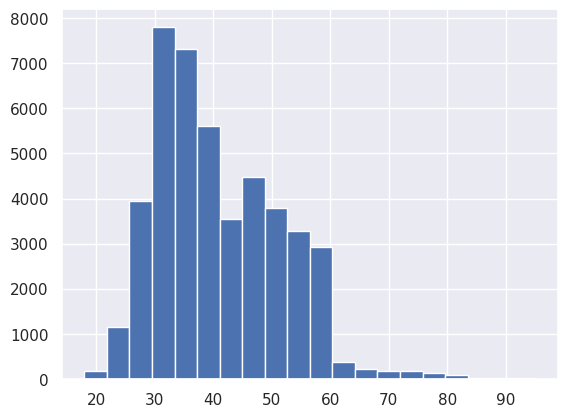

In [30]:
histograma_normal('age')

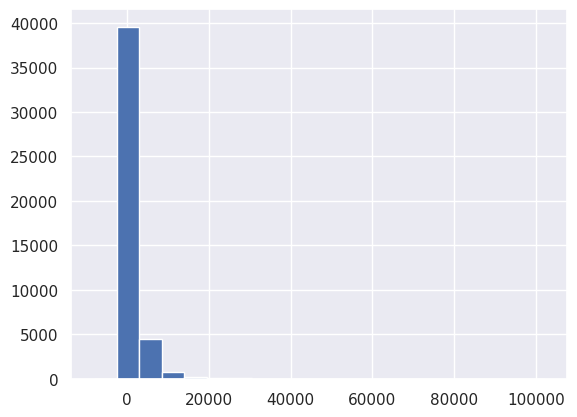

In [ ]:
histograma_normal('balance')

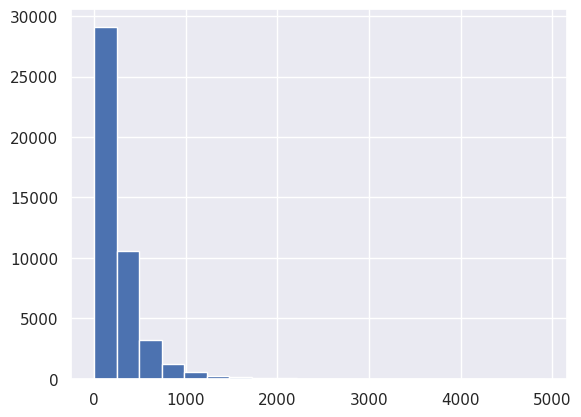

In [ ]:
histograma_normal('duration')

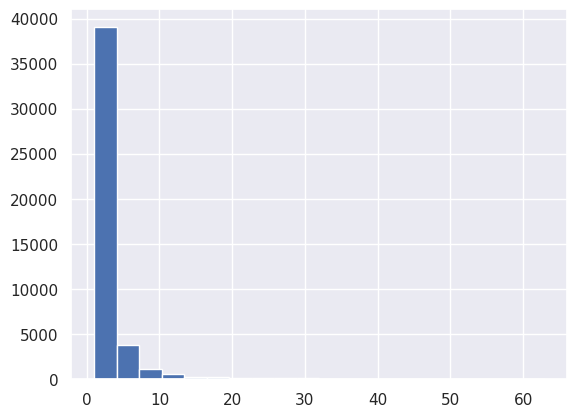

In [31]:
histograma_normal('campaign')

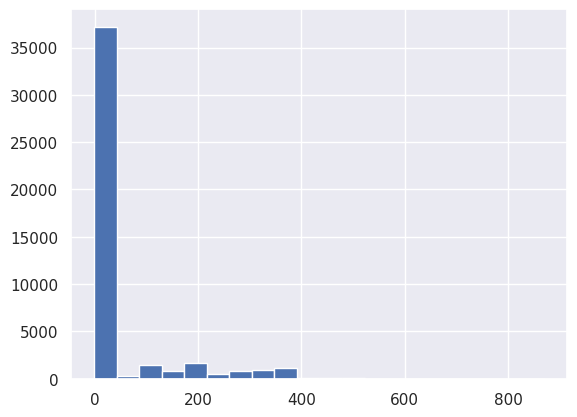

In [32]:
histograma_normal('pdays')

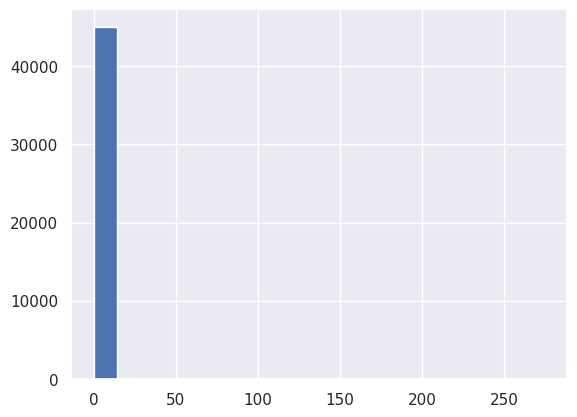

In [33]:
histograma_normal('previous')

## Outliers

In [ ]:
# Las variables numéricas que no tienen distribución normal
vars_no_normal = ['age','balance','duration','campaign','pdays','previous']

#Función para separar los registros dependiendo si son o no outliers 'extremos'
def tukey_outliers(df,column,extreme=False):
  q1=df.select(F.percentile_approx(column, 0.25, 1000000)).take(1)[0][0]
  q3=df.select(F.percentile_approx(column, 0.75, 1000000)).take(1)[0][0]
  iqr = q3 - q1
  constant = 1.5 if not extreme else 3
  nuevo_df = df.select(column).where((F.col(column)<=(q3+constant*iqr)) & (F.col(column)>=(q1-constant*iqr)))
  outliers = df.select(column).where((F.col(column)>(q3+constant*iqr)) | (F.col(column)<(q1-constant*iqr)))
  return nuevo_df,outliers

La columna age tiene un 0.01% de valores nulos.
La columna balance tiene un 5.40% de valores nulos.
La columna duration tiene un 2.55% de valores nulos.
La columna campaign tiene un 3.23% de valores nulos.
La columna pdays tiene un 18.26% de valores nulos.
La columna previous tiene un 18.26% de valores nulos.


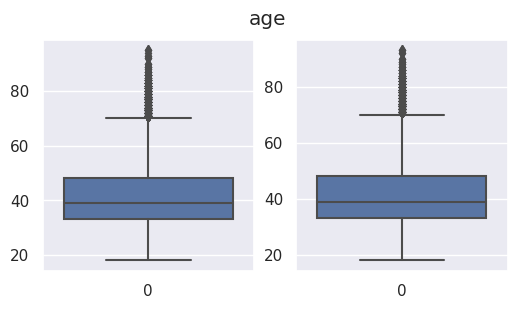

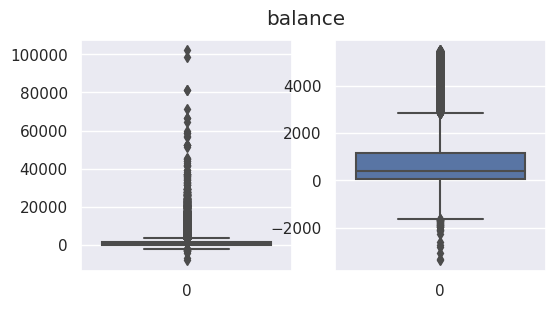

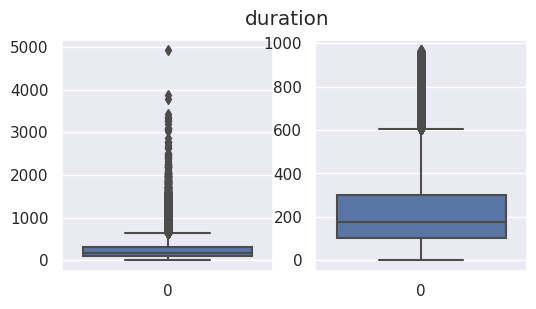

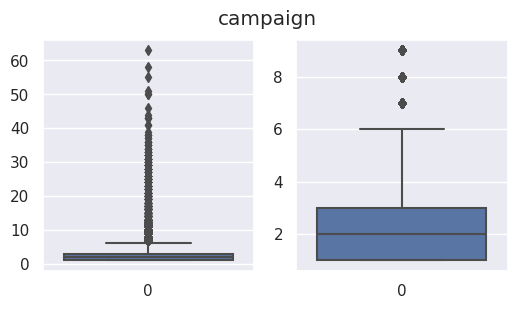

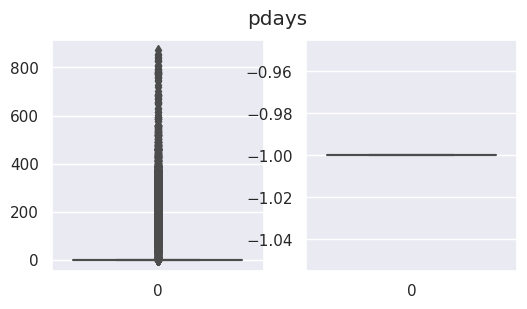

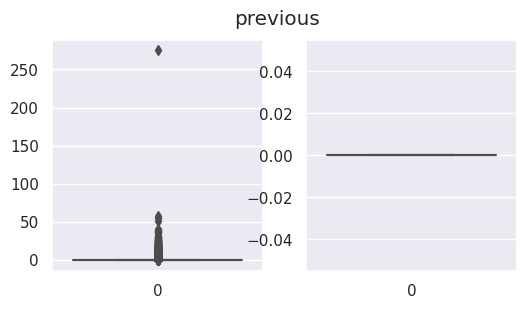

In [ ]:
# Comparamos cómo se comportan las variables al eliminar outliers "extremos"
for col in vars_no_normal:
  df2 = tukey_outliers(df,col,True)[0]

  aux = [val[0] for val in df.select(col).collect()]
  aux2 = [val[0] for val in df2.select(col).collect()]

  print('La columna {a} tiene un {b:0.2f}% de valores nulos.'.format(a=col,b=100*(len(aux)-len(aux2))/len(aux)))

  fig, axes = plt.subplots(1, 2, figsize=(6, 3),sharey=False)

  fig.suptitle(col)

  sns.boxplot(aux,ax=axes[0])
  sns.boxplot(aux2,ax=axes[1])

Notamos que para las variables pdays y previus se identificaron con un porcentaje alto de outliers. Esto debido a que muchos clientes no fueron contactados en la campaña anterior, ocasionando que las distribuciones de las variables tengan un sesgo positivo.

## Balanceo de clases

Text(0.5, 1.0, 'Distribución Variable Objetivo')

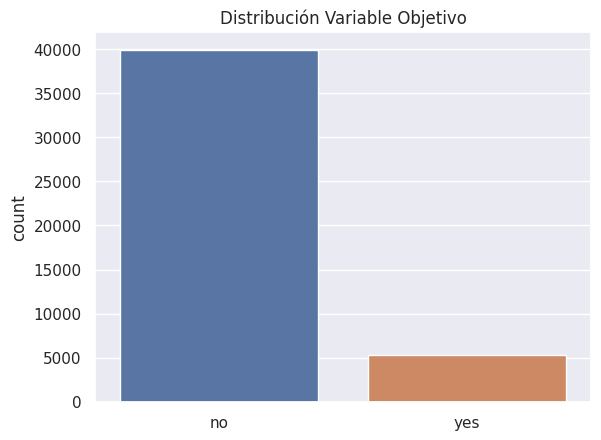

In [ ]:
sns.countplot(x=[val[0] for val in df.select('y').collect()])
plt.title('Distribución Variable Objetivo')

Observamos que tenemos un desbalanceo de clases en la variable objetivo. Dicho desbalanceo puede abordarse con técnicas de oversamplig o undersampling modificando los datos que se utilizarán para el entretamiento y evaluación del modelo. También se pueden mantener los mismo datos y, en caso de ser posible, agregar un hiperparámetro de 'weight' al modelo que se decida utilizar.

# Análisis Exploratorio

## Strings/Categóricas

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

In [ ]:
###Aplicamos stringIndexer para columnas de tipo string o boolean
binary_columns = ['default', 'housing','loan','y']

original_numerical_columns = [item[0] for item in df.dtypes if item[1] in ['double', 'float', 'int']]
string_columns = [item[0] for item in df.dtypes if item[1]=='string']
df_many_steps = df


df_many_steps = df

for col in string_columns:
    print(col)
    string_indexer = StringIndexer(inputCol=col, outputCol=col+"_encoded")
    string_indexer_model = string_indexer.fit(df_many_steps)
    df_many_steps = string_indexer_model.transform(df_many_steps)

    if col not in binary_columns:
        onehotencoder = OneHotEncoder(dropLast=False, inputCol= string_indexer.getOutputCol(), outputCol=col+"_encoded_tmp")
        onehotencoder_model = onehotencoder.fit(df_many_steps)
        df_many_steps = onehotencoder_model.transform(df_many_steps)
        df_many_steps = df_many_steps.drop(string_indexer.getOutputCol())
        df_many_steps = df_many_steps.withColumnRenamed(onehotencoder.getOutputCol(),string_indexer.getOutputCol())


job
marital
education
default
housing
loan
contact
month
poutcome
y


In [ ]:
df_many_steps.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------------+---------------+-----------------+---------------+---------------+------------+---------------+--------------+----------------+---------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|    job_encoded|marital_encoded|education_encoded|default_encoded|housing_encoded|loan_encoded|contact_encoded| month_encoded|poutcome_encoded|y_encoded|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+---------------+---------------+-----------------+---------------+---------------+------------+---------------+--------------+----------------+---------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no| (12,[1],[1.0])|  (3,[

In [ ]:
encoded_columns = [x for x in df_many_steps.columns if '_encoded' in x]
encoded_columns

['job_encoded',
 'marital_encoded',
 'education_encoded',
 'default_encoded',
 'housing_encoded',
 'loan_encoded',
 'contact_encoded',
 'month_encoded',
 'poutcome_encoded',
 'y_encoded']

## Creación de variables

En caso de que consideren oportuno, añadir columnas al dataset

In [ ]:
#Andy

## Matriz de correlación

In [ ]:
df_correlacion=df
## Seleccionamos las variables numéricas que no sean day
num_cols=[c for c, t in df.dtypes if t.startswith('int') and c!='day']

assembler = VectorAssembler(inputCols=num_cols, outputCol='assembled_features')
df_correlacion = assembler.transform(df_correlacion)

# Calculamos la matriz de correlación
matriz = Correlation.corr(df_correlacion, 'assembled_features')
# Obtenemos los valores de las correlaciones en un np.array
matriz_corr=matriz.collect()[0]["pearson({})".format('assembled_features')].values
# Guardamos la matriz de correlación en un df
matriz_corr = pd.DataFrame(matriz_corr.reshape((6,6)), columns=num_cols,index=num_cols)
matriz_corr

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.021560,-0.014578,0.003435,0.016674
duration,-0.004648,0.021560,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,0.001203,-0.032855,0.454820,1.000000


<Axes: >

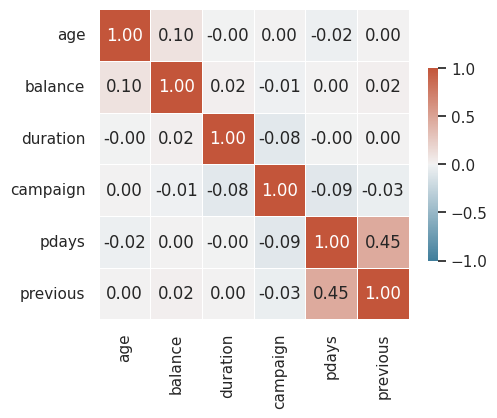

In [ ]:
f, ax = plt.subplots(figsize=(5, 5))

# Color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap de la matriz de correlación
sns.heatmap(matriz_corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')

## Elección de variables
Una vez identificadas las variables correlacionadas ¿con cuáles de ellas te quedas?

Observamos que en general, las correlaciones entre variables son muy bajas. La correlación entre pday y previous es la más alta que se tiene (0.35). Por lo anterior decidimos utilizar todas las variables numéricas para el modelo que se generará.

# Modelos

## Selección de variables

Implementar alguna técnica para seleccionar las variables más significativas

In [ ]:
## mismo método que el notebook ML end to end

encoded_columns = [x for x in df_many_steps.columns if '_encoded' in x and x !='y_encoded']
to_vector_assembler = encoded_columns + original_numerical_columns
to_vector_assembler
vectorassembler = VectorAssembler(inputCols = to_vector_assembler, outputCol='assembled_features')
df_assembled = vectorassembler.transform(df_many_steps)
df_assembled = df_assembled.select(F.col('assembled_features'),'y_encoded')
df_assembled.show()


+--------------------+---------+
|  assembled_features|y_encoded|
+--------------------+---------+
|(48,[1,12,16,23,2...|      0.0|
|(48,[2,13,15,23,2...|      0.0|
|(48,[7,12,15,21,2...|      0.0|
|(48,[0,12,18,23,2...|      0.0|
|(48,[11,13,18,20,...|      0.0|
|(48,[1,12,16,23,2...|      0.0|
|(48,[1,13,16,21,2...|      0.0|
|(48,[7,14,16,19,2...|      0.0|
|(48,[5,12,17,23,2...|      0.0|
|(48,[2,13,15,23,2...|      0.0|
|(48,[3,14,15,23,2...|      0.0|
|(48,[3,13,15,23,2...|      0.0|
|(48,[2,12,15,23,2...|      0.0|
|(48,[2,12,18,23,2...|      0.0|
|(48,[4,12,15,23,2...|      0.0|
|(48,[5,12,17,23,2...|      0.0|
|(48,[3,13,18,23,2...|      0.0|
|(48,[0,12,17,23,2...|      0.0|
|(48,[5,12,17,23,2...|      0.0|
|(48,[4,12,15,23,2...|      0.0|
+--------------------+---------+
only showing top 20 rows



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
import random

random_seed = 4
num_iter = 10

random.seed(random_seed)

random_seeds=set([random.randint(0,10000) for _ in range(num_iter)])
features_random_seed = {}
random_seeds

{324, 1089, 1476, 1690, 2539, 3867, 4969, 6489, 6579, 7845}

In [ ]:
columnas_assembled=[x["name"] for x in sorted(df_assembled.schema["assembled_features"].metadata["ml_attr"]["attrs"]["binary"]+
   df_assembled.schema["assembled_features"].metadata["ml_attr"]["attrs"]["numeric"]+
   df_assembled.schema["assembled_features"].metadata["ml_attr"]["attrs"]["nominal"],
   key=lambda x: x["idx"])]

In [ ]:
for random_seed in random_seeds:
    rf = RandomForestClassifier(featuresCol='assembled_features', labelCol='y_encoded', seed = random_seed)
    rf_model = rf.fit(df_assembled)

    importances = [(index, value) for index, value in enumerate(rf_model.featureImportances.toArray().tolist())]

    importances = sorted(importances, key=lambda value: value[1], reverse=True)

    imp = 0
    vector_assembler_cols =columnas_assembled
    for element in importances:
        feature = vector_assembler_cols[element[0]]
        importance = element[1]

        if imp < 0.95:
            features_random_seed[feature] = features_random_seed.get(feature, []) + [importance]
        else:
            features_random_seed[feature] = features_random_seed.get(feature, []) + [None]
        imp += element[1]

In [ ]:
features_random_seed = pd.DataFrame(features_random_seed).T
features_random_seed

,0,1,2,3,4,5,6,7,8,9
duration,0.390164,0.356665,0.403336,0.325537,0.384402,0.401018,0.386209,0.288164,0.307188,0.372334
poutcome_encoded_success,0.171806,0.232933,0.227746,0.221011,0.240728,0.319238,0.316261,0.310748,0.311337,0.198026
pdays,0.065393,0.081406,0.068697,0.053572,0.04479,0.043306,0.035045,0.08686,0.065481,0.100355
housing_encoded,0.057022,0.046707,0.033088,0.029071,0.041409,0.041133,0.030027,0.051586,0.044865,0.037098
previous,0.051606,0.043229,0.009587,0.060251,0.058715,0.010835,0.017439,0.011622,0.036782,0.028127
poutcome_encoded_unknown,0.033548,0.018174,0.013262,0.049824,0.024575,0.016685,0.035832,0.033191,0.042469,0.045649
contact_encoded_unknown,0.033523,0.014438,0.021547,0.029303,0.024817,0.012965,0.027284,0.021683,0.026663,0.016732
month_encoded_sep,0.032273,0.012041,0.010869,0.01874,0.020319,NaN,0.01096,0.013761,0.017628,0.012567
month_encoded_mar,0.025573,0.018546,0.039618,0.055788,0.038419,0.028324,0.023886,0.024941,0.033224,0.020987
age,0.025305,0.031066,0.05957,0.030702,0.014457,0.034316,0.038203,0.018269,0.03108,0.033005


In [ ]:
feature_importances = features_random_seed.dropna(how='all').mean(axis=1)
feature_importances

duration                    0.361502
poutcome_encoded_success    0.254983
pdays                       0.064490
housing_encoded             0.041201
previous                    0.032819
poutcome_encoded_unknown    0.031321
contact_encoded_unknown     0.022895
month_encoded_sep           0.016573
month_encoded_mar           0.030930
age                         0.031597
month_encoded_oct           0.017762
poutcome_encoded_failure    0.023923
contact_encoded_cellular    0.011669
month_encoded_may           0.014613
day                         0.008686
balance                     0.008006
month_encoded_jul           0.007303
month_encoded_nov           0.005397
month_encoded_apr           0.006181
poutcome_encoded_other      0.011466
dtype: float64

## Algoritmos

In [ ]:
#Random Forest



In [34]:
# logística, random forest, árbol de decisión
df_train, df_test = df_assembled.randomSplit([0.8, 0.2])

thld_label_1 = 0.45  # Try other values, like:  0.01 , 0.15, 0.30, 0.5 (default)
logistic_regression = LogisticRegression(featuresCol= 'assembled_features', labelCol='y_encoded', threshold=thld_label_1 )

logistic_regression_model = logistic_regression.fit(df_train)
print("Logistic regression coefficients: " + str(logistic_regression_model.coefficientMatrix))
print("Logistic regression intercept: " + str(logistic_regression_model.interceptVector))

df_logistic_regression = logistic_regression_model.transform(df_test)

df_logistic_regression.show(5, truncate=False)


Logistic regression coefficients: DenseMatrix([[-1.53242364e-01,  1.25760854e-02, -2.32655823e-02,
               1.47768091e-01, -4.92975459e-02,  4.48089985e-01,
              -6.55382635e-02, -1.61722938e-01,  4.32510880e-02,
              -3.03285643e-01,  4.91769265e-01, -1.06601416e-01,
              -1.42952942e-01,  1.32674484e-01,  7.15796292e-02,
              -3.75145793e-02,  1.78971660e-01, -2.30143951e-01,
               4.64231435e-02, -3.58354039e-02,  6.89073328e-01,
              -4.71601782e-01,  6.69377510e-01, -9.08192269e-01,
               5.43551180e-01, -2.79018500e-02, -4.42811791e-01,
              -3.48365824e-01,  8.09305674e-01, -5.63741173e-01,
               3.35233889e-01,  2.28376286e-01, -8.64680695e-01,
               1.16289615e+00,  1.23178696e+00,  1.95661372e+00,
               9.66795752e-01, -3.18336164e-01, -1.99332609e-01,
              -2.36933050e-02,  2.10759909e+00,  3.09046484e-04,
               1.35518622e-05,  8.58224524e-03,  4.15441

In [ ]:
#Árbol de decisión


## Métricas de evaluación

In [35]:
def calculate_metrics_binary(dataset, predictionCol, labelCol):
    binarymetrics = BinaryClassificationEvaluator(rawPredictionCol=predictionCol, labelCol=labelCol)

    area_under_pr = binarymetrics.evaluate(dataset, {binarymetrics.metricName: "areaUnderPR"})
    area_under_roc = binarymetrics.evaluate(dataset, {binarymetrics.metricName: "areaUnderROC"})

    # We will call a function from mllib library. Therefore, we will be working with a RDD instead of working with a DataFrame
    mmc = MulticlassMetrics(dataset.select(predictionCol, labelCol).rdd)
    conf_matrix = mmc.confusionMatrix().toArray()

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (TN + TP) / dataset.count()

    return {'accuracy': accuracy,
           'recall': recall,
           'precision': precision,
           'f1': f1,
           'area_under_pr': area_under_pr,
           'area_under_roc': area_under_roc}

In [36]:
calculate_metrics_binary(df_logistic_regression, 'prediction', 'y_encoded')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


{'accuracy': 0.9043382756727073,
 'recall': 0.3915094339622642,
 'precision': 0.6474258970358814,
 'f1': 0.4879482657260435,
 'area_under_pr': 0.4858697206052427,
 'area_under_roc': 0.6817087256821887}

## ¿Qué modelo seleccionas y por qué?

Notamos que la regresión logística no tuvo un buen desempeño. Al tener la variable objetivo desbalanceada, no tomamos en cuenta la métrica accuracy. Las demás métricas mustran un mal desempeño del modelo